In [1]:
import os

import pandas as pd
import numpy as np
from time import time
from joblib import load, dump

from fire_modules import severity_matrix as sm

In [2]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score

In [3]:
seed = 42

In [4]:
csv_path = os.path.join('data', 'fires_transformed.csv')
df = pd.read_csv(csv_path)
df.sample(5, random_state=seed)

,elevacion,erodi,slope,orientacion_sen,orientacion_cos,altura,lfcc,inflam,mcroth,anomalia,dpv,vel_media_viento,severidad_real,severidad_discreta,coord_x_etrs89,coord_y_etrs89,incendio,provincia
119340,1024.904053,4,15.177,0.994650,0.103298,9.0,46.956501,3,2,73.561211,2.246882,2.916394,0.845614,3,490110.0,4538190.0,Cogolludo,Guadalajara
58023,505.352997,1,25.718,0.206331,0.978482,3.0,19.892401,4,3,86.961823,2.385298,4.876472,0.270908,1,604950.0,4257480.0,Talave,Albacete
46997,388.710999,2,31.593,-0.984000,0.178167,1.0,0.956900,4,3,79.168137,2.319516,5.026659,0.412787,1,617730.0,4243860.0,Donceles,Albacete
67214,1063.177002,1,22.364,0.901304,-0.433188,2.0,7.424201,4,1,50.321835,0.349119,2.470344,0.576249,2,561090.0,4256790.0,Yeste,Albacete
153590,507.516998,3,13.911,0.872081,0.489362,3.0,32.275799,4,3,72.893860,1.469779,3.393716,0.310006,1,407340.0,4412550.0,Montesion,Toledo


In [5]:
numerical_variables = ['elevacion', 'slope', 'orientacion_sen', 'orientacion_cos', 'altura', 'lfcc', 'anomalia', 'dpv', 'vel_media_viento']
categorical_variables = ['erodi', 'inflam', 'mcroth']
variables = numerical_variables + categorical_variables
target_real = 'severidad_real'
target_discrete = 'severidad_discreta'

coords_columns = ['coord_x_etrs89', 'coord_y_etrs89']

In [6]:
fire_names = list(df['incendio'].unique())
test_fire_names = ['Agramon', 'Almansa', 'Malagon', 'La_Iglesuela']
train_fire_names = [x for x in fire_names if x not in test_fire_names]

print(f'Train: {train_fire_names}')
print(f'Test:  {test_fire_names}')

Train: ['Donceles', 'Lietor', 'Talave', 'Yeste', 'Cañada_del_Hoyo', 'Bustares', 'Cogolludo', 'Almorox', 'Cadalso', 'Montesion', 'Villanueva_de_Bogas']
Test:  ['Agramon', 'Almansa', 'Malagon', 'La_Iglesuela']


In [7]:
df_train = df[df['incendio'].isin(train_fire_names)].reset_index(drop=True)
print(len(df_train))
df_train.head()

133092


,elevacion,erodi,slope,orientacion_sen,orientacion_cos,altura,lfcc,inflam,mcroth,anomalia,dpv,vel_media_viento,severidad_real,severidad_discreta,coord_x_etrs89,coord_y_etrs89,incendio,provincia
0,474.993988,1,2.988,0.591536,0.806278,4.0,13.578500,4,3,78.942978,2.530710,5.199876,0.153908,0,607110.0,4256310.0,Donceles,Albacete
1,472.980011,1,2.177,0.997200,0.074776,8.0,10.838201,4,3,78.941406,2.531341,5.200114,0.174595,0,607140.0,4256310.0,Donceles,Albacete
2,466.144989,1,7.510,0.977572,-0.210601,9.0,17.604599,4,3,78.936714,2.533220,5.200821,0.176796,0,607230.0,4256310.0,Donceles,Albacete
3,475.859985,1,3.765,0.762302,0.647222,4.0,14.039700,4,3,78.944611,2.529883,5.199497,0.168421,0,607110.0,4256280.0,Donceles,Albacete
4,473.007996,1,3.792,0.986111,0.166089,4.0,16.137899,4,3,78.943054,2.530514,5.199735,0.202057,0,607140.0,4256280.0,Donceles,Albacete


In [8]:
df_test = df[df['incendio'].isin(test_fire_names)].reset_index(drop=True)
print(len(df_test))
df_test.head()

24441


,elevacion,erodi,slope,orientacion_sen,orientacion_cos,altura,lfcc,inflam,mcroth,anomalia,dpv,vel_media_viento,severidad_real,severidad_discreta,coord_x_etrs89,coord_y_etrs89,incendio,provincia
0,482.423004,1,15.401000,0.091827,0.995775,10.0,13.2000,3,3,80.210800,1.464469,2.855457,0.155662,0,615180.0,4257300.0,Agramon,Albacete
1,487.563995,1,20.632999,0.087687,0.996148,1.0,0.7326,3,3,80.228157,1.463829,2.855017,0.224380,0,614850.0,4257270.0,Agramon,Albacete
2,486.273987,1,12.380000,-0.129868,0.991531,1.0,5.1383,3,3,80.207359,1.464057,2.855563,0.308407,1,615120.0,4257270.0,Agramon,Albacete
3,495.325989,1,21.625000,0.222399,0.974956,1.0,1.4184,3,3,80.210716,1.463563,2.855489,0.207618,0,614970.0,4257240.0,Agramon,Albacete
4,490.188995,1,19.408001,-0.010958,0.999940,4.0,7.4510,3,3,80.206093,1.463614,2.855611,0.292563,1,615030.0,4257240.0,Agramon,Albacete


In [9]:
def optimize_params(estimator, X, y, cv, scoring=None, refit=True, **param_grid):
    t = time()

    # GridSearch over specified parameter values for an estimator
    grid_search_cv = GridSearchCV(estimator,
                                  param_grid,
                                  scoring=scoring,
                                  refit=False,  # Disable automatic refit to manually select best estimator
                                  cv=cv,
                                  verbose=1,
                                  n_jobs=10,
                                  return_train_score=True).fit(X, y)

    cv_results = pd.DataFrame(grid_search_cv.cv_results_)   

    # Calculate weighted sizes of each fold
    sizes_train = []
    sizes_test = []
    for train_indexes, test_indexes in cv:
        sizes_train.append(len(train_indexes))
        sizes_test.append(len(test_indexes))
    total_sizes_train = sum(sizes_train)
    total_sizes_test = sum(sizes_test)
    weighted_sizes_train = [x / total_sizes_train for x in sizes_train]
    weighted_sizes_test = [x / total_sizes_test for x in sizes_test]

    # Calculate weighted mean score for train and test
    weighted_mean_train_score = sum(cv_results[f'split{i}_train_score'] * weighted_sizes_train[i] for i in range(len(weighted_sizes_train)))
    cv_results.insert(cv_results.columns.get_loc('mean_train_score'), 'weighted_mean_train_score', weighted_mean_train_score)
    weighted_mean_test_score = sum(cv_results[f'split{i}_test_score'] * weighted_sizes_test[i] for i in range(len(weighted_sizes_test)))
    cv_results.insert(cv_results.columns.get_loc('mean_test_score'), 'weighted_mean_test_score', weighted_mean_test_score)

    # Order params by the weighted mean test score
    cv_results = cv_results.sort_values(by='weighted_mean_test_score', ascending=False)
    cv_results['rank_test_score'] = range(1, len(cv_results) + 1)

    # Drop the results for each validation split
    labels = cv_results.filter(regex="split")
    cv_results = cv_results.drop(labels, axis=1)

    print(f'Time: {round(time()-t, 2)} seg.')
    display(cv_results)

    
    grid_search_cv.best_index_ = cv_results.index[0]
    grid_search_cv.best_params_ = cv_results.loc[grid_search_cv.best_index_, 'params']
    grid_search_cv.best_score_ = cv_results.loc[grid_search_cv.best_index_, 'weighted_mean_test_score']
    # Refit with best params
    if refit:
        grid_search_cv.best_estimator_ = grid_search_cv.estimator.set_params(**grid_search_cv.best_params_).fit(X, y)
    

    return grid_search_cv

In [10]:
preprocessing = make_column_transformer(
        (StandardScaler(), numerical_variables),
        (OneHotEncoder(handle_unknown='ignore'), categorical_variables),
        remainder='passthrough'
)

In [11]:
def reclass(new_classification, df):
    df_copy = df.copy()
    df_copy = df_copy[df_copy[target_discrete].isin(list(new_classification.keys()))].reset_index(drop=True)
    df_copy[target_discrete] = df_copy[target_discrete].map(new_classification, na_action='ignore')
    return df_copy

# Baja - Alta

In [12]:
new_classification = {0:0, 1:0, 2:1, 3:1}

df_train_reclass = reclass(new_classification, df_train)
df_test_reclass = reclass(new_classification, df_test)

In [13]:
X_train = df_train_reclass[variables]
y_train = df_train_reclass[target_discrete]

X_test = df_test_reclass[variables]
y_test = df_test_reclass[target_discrete]

In [14]:
folds = []

for name in train_fire_names:
    fold_train_names = [x for x in train_fire_names if x != name]
    fold_test_name = [x for x in train_fire_names if x == name]

    fold_train_indices = df_train_reclass[(df_train_reclass['incendio'].isin(fold_train_names))].index
    fold_test_indices = df_train_reclass[df_train_reclass['incendio'].isin(fold_test_name)].index
    folds.append((fold_train_indices, fold_test_indices))

[print(f'Fold {i}: Train: {x.size}\tTest:{y.size}') for i, (x, y) in enumerate(folds)];

Fold 0: Train: 89881	Test:43211
Fold 1: Train: 126960	Test:6132
Fold 2: Train: 124441	Test:8651
Fold 3: Train: 106022	Test:27070
Fold 4: Train: 130108	Test:2984
Fold 5: Train: 130127	Test:2965
Fold 6: Train: 117139	Test:15953
Fold 7: Train: 122027	Test:11065
Fold 8: Train: 126495	Test:6597
Fold 9: Train: 125318	Test:7774
Fold 10: Train: 132402	Test:690


## Grid Search

### Logistic Regression

In [15]:
poly = PolynomialFeatures(include_bias=False)
logistic_reg = LogisticRegression(random_state=seed)
logistic_reg_pipeline = make_pipeline(preprocessing, poly, logistic_reg)

param_grid = {
    'polynomialfeatures__degree': [1, 2],
    'logisticregression__C': [0.01, 0.1, 1, 2, 5, 10],
    'logisticregression__max_iter': [100, 200]
}

logistic_reg_gs = optimize_params(logistic_reg_pipeline, X_train, y_train, folds, scoring='f1', **param_grid)

Fitting 11 folds for each of 24 candidates, totalling 264 fits
Time: 310.59 seg.


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logisticregression__C,param_logisticregression__max_iter,param_polynomialfeatures__degree,params,weighted_mean_test_score,mean_test_score,std_test_score,rank_test_score,weighted_mean_train_score,mean_train_score,std_train_score
23,24.213928,4.160897,0.081876,0.095516,10,200,2,"{'logisticregression__C': 10, 'logisticregress...",0.263943,0.238203,0.257292,1,0.553112,0.552783,0.020929
19,26.571600,2.912283,0.100050,0.086869,5,200,2,"{'logisticregression__C': 5, 'logisticregressi...",0.263808,0.238292,0.255976,2,0.553736,0.553403,0.020440
15,26.788612,2.878830,0.099192,0.088331,2,200,2,"{'logisticregression__C': 2, 'logisticregressi...",0.261203,0.237671,0.254385,3,0.553419,0.553087,0.020940
11,26.538107,2.844414,0.098297,0.083964,1,200,2,"{'logisticregression__C': 1, 'logisticregressi...",0.253954,0.227378,0.255905,4,0.553101,0.552773,0.020805
22,1.406504,0.161892,0.037960,0.028429,10,200,1,"{'logisticregression__C': 10, 'logisticregress...",0.252607,0.154576,0.179269,5,0.393610,0.394647,0.015200
20,1.399161,0.175737,0.037913,0.023247,10,100,1,"{'logisticregression__C': 10, 'logisticregress...",0.252607,0.154576,0.179269,6,0.393610,0.394647,0.015200
18,1.392221,0.203334,0.036999,0.022652,5,200,1,"{'logisticregression__C': 5, 'logisticregressi...",0.252607,0.154576,0.179269,7,0.393605,0.394643,0.015206
16,1.387351,0.167763,0.036824,0.025853,5,100,1,"{'logisticregression__C': 5, 'logisticregressi...",0.252607,0.154576,0.179269,8,0.393605,0.394643,0.015206
14,1.398846,0.188194,0.040335,0.026710,2,200,1,"{'logisticregression__C': 2, 'logisticregressi...",0.252445,0.154516,0.179203,9,0.393593,0.394627,0.015182
12,1.396691,0.210200,0.036968,0.025181,2,100,1,"{'logisticregression__C': 2, 'logisticregressi...",0.252445,0.154516,0.179203,10,0.393593,0.394627,0.015182


c:\Users\Alejandro.Martinez\AppData\Local\miniconda3\envs\tfm_env\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### KNeighbors

In [16]:
k_neighbors_class = KNeighborsClassifier()
k_neighbours_class_pipeline = make_pipeline(preprocessing, k_neighbors_class)

param_grid = {
    'kneighborsclassifier__n_neighbors': [5, 10, 20, 50, 100],
    'kneighborsclassifier__weights': ['uniform', 'distance']
}

k_neighbors_class_gs = optimize_params(k_neighbours_class_pipeline, X_train, y_train, folds, scoring='f1', **param_grid)

Fitting 11 folds for each of 10 candidates, totalling 110 fits
Time: 1976.48 seg.


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_kneighborsclassifier__n_neighbors,param_kneighborsclassifier__weights,params,weighted_mean_test_score,mean_test_score,std_test_score,rank_test_score,weighted_mean_train_score,mean_train_score,std_train_score
1,0.108647,0.010979,14.176850,11.617140,5,distance,"{'kneighborsclassifier__n_neighbors': 5, 'knei...",0.242973,0.240495,0.131180,1,1.000000,1.000000,0.000000
0,0.145936,0.020518,14.443338,11.931243,5,uniform,"{'kneighborsclassifier__n_neighbors': 5, 'knei...",0.242968,0.240486,0.131179,2,0.724646,0.724564,0.012402
3,0.106318,0.025831,14.308892,12.065588,10,distance,"{'kneighborsclassifier__n_neighbors': 10, 'kne...",0.218887,0.226831,0.133896,3,1.000000,1.000000,0.000000
5,0.107484,0.019258,14.085793,11.740139,20,distance,"{'kneighborsclassifier__n_neighbors': 20, 'kne...",0.187830,0.214072,0.122574,4,1.000000,1.000000,0.000000
2,0.099223,0.008358,14.515868,12.145797,10,uniform,"{'kneighborsclassifier__n_neighbors': 10, 'kne...",0.176184,0.188721,0.123780,5,0.653674,0.653499,0.017217
4,0.107245,0.011467,14.312665,11.935708,20,uniform,"{'kneighborsclassifier__n_neighbors': 20, 'kne...",0.164612,0.190853,0.116647,6,0.632526,0.632278,0.018061
7,0.110572,0.013666,14.812500,12.433975,50,distance,"{'kneighborsclassifier__n_neighbors': 50, 'kne...",0.152175,0.178254,0.154609,7,1.000000,1.000000,0.000000
6,0.112595,0.010226,14.932653,12.686116,50,uniform,"{'kneighborsclassifier__n_neighbors': 50, 'kne...",0.143946,0.171423,0.153969,8,0.610955,0.610633,0.019693
9,0.113331,0.013455,15.455868,12.942605,100,distance,"{'kneighborsclassifier__n_neighbors': 100, 'kn...",0.136591,0.167026,0.167367,9,1.000000,1.000000,0.000000
8,0.111054,0.010447,15.090544,12.660933,100,uniform,"{'kneighborsclassifier__n_neighbors': 100, 'kn...",0.132414,0.161919,0.167229,10,0.595341,0.594966,0.020747


### Decision Tree

In [17]:
decision_tree_class = DecisionTreeClassifier(random_state=seed)
decision_tree_class_pipeline = make_pipeline(preprocessing, decision_tree_class)

param_grid = {
    'decisiontreeclassifier__max_depth': [3, 5, 7, 10, None],
    'decisiontreeclassifier__min_samples_split': [2, 50, 200],
    'decisiontreeclassifier__criterion': ['entropy', 'gini'],
    'decisiontreeclassifier__ccp_alpha': [0, 0.0001, 0.001, 0.01, 0.1]
}

decision_tree_class_gs = optimize_params(decision_tree_class_pipeline, X_train, y_train, folds, scoring='f1', **param_grid)

Fitting 11 folds for each of 150 candidates, totalling 1650 fits
Time: 621.59 seg.


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_decisiontreeclassifier__ccp_alpha,param_decisiontreeclassifier__criterion,param_decisiontreeclassifier__max_depth,params,weighted_mean_test_score,mean_test_score,std_test_score,rank_test_score,weighted_mean_train_score,mean_train_score,std_train_score
27,6.561454,0.699364,0.018096,0.009575,0,gini,None,"{'decisiontreeclassifier__ccp_alpha': 0, 'deci...",0.314719,0.294511,0.144739,1,1.000000,1.000000,0.000000
28,6.065903,0.651037,0.019081,0.011196,0,gini,None,"{'decisiontreeclassifier__ccp_alpha': 0, 'deci...",0.285787,0.233653,0.195133,2,0.812420,0.812337,0.013242
25,3.990953,0.409390,0.018755,0.011183,0,gini,10,"{'decisiontreeclassifier__ccp_alpha': 0, 'deci...",0.189190,0.151811,0.145866,3,0.664491,0.664518,0.020288
12,7.467634,0.798197,0.019171,0.010068,0,entropy,None,"{'decisiontreeclassifier__ccp_alpha': 0, 'deci...",0.180768,0.191384,0.111463,4,1.000000,1.000000,0.000000
29,5.353477,0.592371,0.017427,0.010070,0,gini,None,"{'decisiontreeclassifier__ccp_alpha': 0, 'deci...",0.158252,0.134789,0.207256,5,0.719777,0.719629,0.019285
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,1.607569,0.160910,0.017127,0.009515,0.1,entropy,3,"{'decisiontreeclassifier__ccp_alpha': 0.1, 'de...",0.000000,0.000000,0.000000,146,0.000000,0.000000,0.000000
122,1.611392,0.146003,0.020313,0.013736,0.1,entropy,3,"{'decisiontreeclassifier__ccp_alpha': 0.1, 'de...",0.000000,0.000000,0.000000,147,0.000000,0.000000,0.000000
123,2.574285,0.250276,0.016353,0.006807,0.1,entropy,5,"{'decisiontreeclassifier__ccp_alpha': 0.1, 'de...",0.000000,0.000000,0.000000,148,0.000000,0.000000,0.000000
124,2.568352,0.247251,0.017491,0.009390,0.1,entropy,5,"{'decisiontreeclassifier__ccp_alpha': 0.1, 'de...",0.000000,0.000000,0.000000,149,0.000000,0.000000,0.000000


### Random Forest

In [18]:
random_forest_class = RandomForestClassifier(random_state=seed)
random_forest_class_pipeline = make_pipeline(preprocessing, random_forest_class)

param_grid = {
    'randomforestclassifier__n_estimators': [10, 25, 50],
    'randomforestclassifier__max_depth': [3, 5, 7, None],
    'randomforestclassifier__criterion': ['entropy', 'gini'],
}

random_forest_class_gs = optimize_params(random_forest_class_pipeline, X_train, y_train, folds, scoring='f1', **param_grid)

Fitting 11 folds for each of 24 candidates, totalling 264 fits
Time: 460.0 seg.


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_randomforestclassifier__criterion,param_randomforestclassifier__max_depth,param_randomforestclassifier__n_estimators,params,weighted_mean_test_score,mean_test_score,std_test_score,rank_test_score,weighted_mean_train_score,mean_train_score,std_train_score
21,11.120901,1.169084,0.033952,0.025309,gini,None,10,"{'randomforestclassifier__criterion': 'gini', ...",0.062165,0.054714,0.053915,1,0.984621,0.984589,0.001405
0,2.797239,0.305968,0.029193,0.015417,entropy,3,10,{'randomforestclassifier__criterion': 'entropy...,0.035141,0.018955,0.044339,2,0.379246,0.380439,0.054487
22,27.002680,2.900198,0.055775,0.044486,gini,None,25,"{'randomforestclassifier__criterion': 'gini', ...",0.026926,0.042571,0.094247,3,0.998187,0.998176,0.000201
18,4.936969,0.502631,0.031342,0.018758,gini,7,10,"{'randomforestclassifier__criterion': 'gini', ...",0.024369,0.021691,0.038470,4,0.546979,0.546501,0.040042
9,12.734376,1.372748,0.031388,0.020494,entropy,None,10,{'randomforestclassifier__criterion': 'entropy...,0.022185,0.018426,0.025333,5,0.984604,0.984568,0.001340
16,9.046446,0.897020,0.047882,0.033305,gini,5,25,"{'randomforestclassifier__criterion': 'gini', ...",0.016459,0.019234,0.041224,6,0.477397,0.478060,0.044038
12,2.345159,0.273923,0.027316,0.014968,gini,3,10,"{'randomforestclassifier__criterion': 'gini', ...",0.014217,0.006937,0.018766,7,0.383913,0.385125,0.053222
4,10.458909,1.051785,0.047692,0.034321,entropy,5,25,{'randomforestclassifier__criterion': 'entropy...,0.008048,0.008569,0.018988,8,0.470937,0.471727,0.047861
23,50.600767,6.170962,0.081390,0.077044,gini,None,50,"{'randomforestclassifier__criterion': 'gini', ...",0.007328,0.004048,0.006626,9,0.999697,0.999697,0.000077
17,17.940036,1.853715,0.074826,0.057167,gini,5,50,"{'randomforestclassifier__criterion': 'gini', ...",0.005889,0.006812,0.014658,10,0.473768,0.474310,0.047941


### XGBoost

In [19]:
xgb_class = XGBClassifier(random_state=seed)
xgb_class_pipeline = make_pipeline(preprocessing, xgb_class)

param_grid = {
    'xgbclassifier__n_estimators': [10, 25, 50, 100],
    'xgbclassifier__max_depth': [3, 5, 7, 10, None],
    'xgbclassifier__learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1, 0.2]
}

xgb_class_gs = optimize_params(xgb_class_pipeline, X_train, y_train, folds, scoring='f1', **param_grid)

Fitting 11 folds for each of 120 candidates, totalling 1320 fits
Time: 324.52 seg.


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_xgbclassifier__learning_rate,param_xgbclassifier__max_depth,param_xgbclassifier__n_estimators,params,weighted_mean_test_score,mean_test_score,std_test_score,rank_test_score,weighted_mean_train_score,mean_train_score,std_train_score
112,1.330928,0.133034,0.041507,0.027559,0.2,10,10,"{'xgbclassifier__learning_rate': 0.2, 'xgbclas...",0.077535,0.074728,0.097492,1,0.730638,0.731032,0.023761
93,2.378817,0.167189,0.056085,0.044385,0.1,10,25,"{'xgbclassifier__learning_rate': 0.1, 'xgbclas...",0.057193,0.065822,0.099404,2,0.745674,0.746064,0.021643
74,4.154432,0.226477,0.073713,0.066145,0.05,10,50,"{'xgbclassifier__learning_rate': 0.05, 'xgbcla...",0.053191,0.069120,0.118693,3,0.745333,0.745741,0.023175
100,0.757800,0.066594,0.031642,0.019343,0.2,3,10,"{'xgbclassifier__learning_rate': 0.2, 'xgbclas...",0.047335,0.038660,0.109877,4,0.426150,0.428891,0.036136
99,2.621356,0.247710,0.074734,0.061572,0.1,None,100,"{'xgbclassifier__learning_rate': 0.1, 'xgbclas...",0.046393,0.052184,0.074905,5,0.687823,0.688137,0.018517
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33,2.536925,0.171388,0.048050,0.029160,0.005,10,25,"{'xgbclassifier__learning_rate': 0.005, 'xgbcl...",0.000000,0.000000,0.000000,116,0.000000,0.000000,0.000000
32,1.406429,0.135674,0.040165,0.023818,0.005,10,10,"{'xgbclassifier__learning_rate': 0.005, 'xgbcl...",0.000000,0.000000,0.000000,117,0.000000,0.000000,0.000000
31,3.775876,0.317284,0.082717,0.068942,0.005,7,100,"{'xgbclassifier__learning_rate': 0.005, 'xgbcl...",0.000000,0.000000,0.000000,118,0.231090,0.232533,0.069340
30,2.176853,0.167950,0.060700,0.045161,0.005,7,50,"{'xgbclassifier__learning_rate': 0.005, 'xgbcl...",0.000000,0.000000,0.000000,119,0.000000,0.000000,0.000000


### SGD

In [20]:
sgd_class = SGDClassifier(random_state=seed)
sgd_class_pipeline = make_pipeline(preprocessing, sgd_class)

param_grid = {
    'sgdclassifier__alpha': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.5, 0.8],
    'sgdclassifier__max_iter': [50, 100, 500, 1000],
    'sgdclassifier__loss': ['log_loss', 'hinge', 'modified_huber'],
    'sgdclassifier__class_weight': ['balanced', None, {0:1, 1:2}]
}

sgd_class_gs = optimize_params(sgd_class_pipeline, X_train, y_train, folds, scoring='f1', **param_grid)

Fitting 11 folds for each of 252 candidates, totalling 2772 fits
Time: 232.17 seg.


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_sgdclassifier__alpha,param_sgdclassifier__class_weight,param_sgdclassifier__loss,param_sgdclassifier__max_iter,params,weighted_mean_test_score,mean_test_score,std_test_score,rank_test_score,weighted_mean_train_score,mean_train_score,std_train_score
9,2.009198,0.240751,0.024097,0.014461,0.0001,balanced,modified_huber,100,"{'sgdclassifier__alpha': 0.0001, 'sgdclassifie...",0.416850,0.314922,0.213146,1,0.563769,0.563269,0.012922
10,2.010749,0.237406,0.023504,0.012170,0.0001,balanced,modified_huber,500,"{'sgdclassifier__alpha': 0.0001, 'sgdclassifie...",0.416850,0.314922,0.213146,2,0.563769,0.563269,0.012922
11,2.033600,0.242219,0.022694,0.012520,0.0001,balanced,modified_huber,1000,"{'sgdclassifier__alpha': 0.0001, 'sgdclassifie...",0.416850,0.314922,0.213146,3,0.563769,0.563269,0.012922
83,0.565376,0.051573,0.025224,0.014342,0.01,balanced,modified_huber,1000,"{'sgdclassifier__alpha': 0.01, 'sgdclassifier_...",0.413692,0.277766,0.216635,4,0.573873,0.573758,0.011813
82,0.564519,0.055584,0.025369,0.013567,0.01,balanced,modified_huber,500,"{'sgdclassifier__alpha': 0.01, 'sgdclassifier_...",0.413692,0.277766,0.216635,5,0.573873,0.573758,0.011813
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,0.434811,0.058361,0.026137,0.015186,0.8,None,hinge,1000,"{'sgdclassifier__alpha': 0.8, 'sgdclassifier__...",0.000000,0.000000,0.000000,248,0.000000,0.000000,0.000000
234,0.447870,0.054595,0.027696,0.016340,0.8,None,hinge,500,"{'sgdclassifier__alpha': 0.8, 'sgdclassifier__...",0.000000,0.000000,0.000000,249,0.000000,0.000000,0.000000
233,0.439991,0.062871,0.025391,0.015483,0.8,None,hinge,100,"{'sgdclassifier__alpha': 0.8, 'sgdclassifier__...",0.000000,0.000000,0.000000,250,0.000000,0.000000,0.000000
232,0.433277,0.055892,0.024187,0.011578,0.8,None,hinge,50,"{'sgdclassifier__alpha': 0.8, 'sgdclassifier__...",0.000000,0.000000,0.000000,251,0.000000,0.000000,0.000000


## Evaluación

In [21]:
models_dict = {
    'Regresion logistica': logistic_reg_gs,
    'KNeighbors' : k_neighbors_class_gs,
    'Arbol de decision': decision_tree_class_gs,
    'Random Forest': random_forest_class_gs,
    'XGBoost': xgb_class_gs,
    'SGD': sgd_class_gs
}


df_results = pd.DataFrame({
    'Modelo': models_dict.keys(),
    'Mejor puntuacion': [gs.best_score_ for gs in models_dict.values()]
})
df_results = df_results.sort_values(by='Mejor puntuacion', ascending=False)
df_results

,Modelo,Mejor puntuacion
5,SGD,0.416850
2,Arbol de decision,0.314719
0,Regresion logistica,0.263943
1,KNeighbors,0.242973
4,XGBoost,0.077535
3,Random Forest,0.062165


In [22]:
best_model = models_dict[df_results.loc[df_results.index[0], 'Modelo']].best_estimator_
model_path = os.path.join('models', 'experiment_3', 'model_baja_alta.joblib')
dump(best_model, model_path)

['models\\experiment_3\\model_baja_alta.joblib']

In [23]:
model_path = os.path.join('models', 'experiment_3', 'model_baja_alta.joblib')
model = load(model_path)
pred = model.predict(X_test)

print(f"""Métricas predicción del test
F1:        {f1_score(y_test, pred)}
Recall:    {recall_score(y_test, pred)}
Precision: {precision_score(y_test, pred)}
Accuracy:  {accuracy_score(y_test, pred)}""")

Métricas predicción del test
F1:        0.5205393820325058
Recall:    0.4508818069306931
Precision: 0.6156527249683144
Accuracy:  0.5606562742931959


# Baja - Media baja

In [24]:
new_classification = {0:0, 1:1}

df_train_reclass = reclass(new_classification, df_train)
df_test_reclass = reclass(new_classification, df_test)

In [25]:
X_train = df_train_reclass[variables]
y_train = df_train_reclass[target_discrete]

X_test = df_test_reclass[variables]
y_test = df_test_reclass[target_discrete]

In [26]:
folds = []

for name in train_fire_names:
    fold_train_names = [x for x in train_fire_names if x != name]
    fold_test_name = [x for x in train_fire_names if x == name]

    fold_train_indices = df_train_reclass[(df_train_reclass['incendio'].isin(fold_train_names))].index
    fold_test_indices = df_train_reclass[df_train_reclass['incendio'].isin(fold_test_name)].index
    folds.append((fold_train_indices, fold_test_indices))

[print(f'Fold {i}: Train: {x.size}\tTest:{y.size}') for i, (x, y) in enumerate(folds)];

Fold 0: Train: 59593	Test:31128
Fold 1: Train: 84849	Test:5872
Fold 2: Train: 83559	Test:7162
Fold 3: Train: 76806	Test:13915
Fold 4: Train: 89874	Test:847
Fold 5: Train: 88740	Test:1981
Fold 6: Train: 80785	Test:9936
Fold 7: Train: 83028	Test:7693
Fold 8: Train: 85681	Test:5040
Fold 9: Train: 84253	Test:6468
Fold 10: Train: 90042	Test:679


## Grid Search

### Logistic Regression

In [27]:
poly = PolynomialFeatures(include_bias=False)
logistic_reg = LogisticRegression(random_state=seed)
logistic_reg_pipeline = make_pipeline(preprocessing, poly, logistic_reg)

param_grid = {
    'polynomialfeatures__degree': [1, 2],
    'logisticregression__C': [0.01, 0.1, 1, 2, 5, 10],
    'logisticregression__max_iter': [100, 200]
}

logistic_reg_gs = optimize_params(logistic_reg_pipeline, X_train, y_train, folds, scoring='f1', **param_grid)

Fitting 11 folds for each of 24 candidates, totalling 264 fits
Time: 204.77 seg.


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logisticregression__C,param_logisticregression__max_iter,param_polynomialfeatures__degree,params,weighted_mean_test_score,mean_test_score,std_test_score,rank_test_score,weighted_mean_train_score,mean_train_score,std_train_score
0,0.976446,0.145456,0.027706,0.012174,0.01,100,1,"{'logisticregression__C': 0.01, 'logisticregre...",0.647614,0.650482,0.126523,1,0.722169,0.721789,0.012193
2,1.045065,0.142906,0.032152,0.017448,0.01,200,1,"{'logisticregression__C': 0.01, 'logisticregre...",0.647614,0.650482,0.126523,2,0.722169,0.721789,0.012193
4,1.131871,0.269175,0.027994,0.014342,0.1,100,1,"{'logisticregression__C': 0.1, 'logisticregres...",0.633912,0.645854,0.128110,3,0.721450,0.721086,0.011995
6,1.130589,0.284735,0.033866,0.018062,0.1,200,1,"{'logisticregression__C': 0.1, 'logisticregres...",0.633912,0.645854,0.128110,4,0.721450,0.721086,0.011995
8,0.869275,0.118437,0.036735,0.018045,1,100,1,"{'logisticregression__C': 1, 'logisticregressi...",0.631855,0.645464,0.127983,5,0.721385,0.721017,0.012017
10,0.882855,0.106813,0.030752,0.019830,1,200,1,"{'logisticregression__C': 1, 'logisticregressi...",0.631855,0.645464,0.127983,6,0.721385,0.721017,0.012017
14,0.888076,0.127927,0.037057,0.025860,2,200,1,"{'logisticregression__C': 2, 'logisticregressi...",0.631717,0.645437,0.128111,7,0.721377,0.721009,0.012005
12,0.877214,0.116456,0.035663,0.024277,2,100,1,"{'logisticregression__C': 2, 'logisticregressi...",0.631717,0.645437,0.128111,8,0.721377,0.721009,0.012005
16,0.903276,0.124903,0.037423,0.026146,5,100,1,"{'logisticregression__C': 5, 'logisticregressi...",0.631695,0.645422,0.128147,9,0.721375,0.721008,0.012004
18,0.891472,0.123380,0.038859,0.022971,5,200,1,"{'logisticregression__C': 5, 'logisticregressi...",0.631695,0.645422,0.128147,10,0.721375,0.721008,0.012004


### KNeighbors

In [28]:
k_neighbors_class = KNeighborsClassifier()
k_neighbours_class_pipeline = make_pipeline(preprocessing, k_neighbors_class)

param_grid = {
    'kneighborsclassifier__n_neighbors': [5, 10, 20, 50, 100],
    'kneighborsclassifier__weights': ['uniform', 'distance']
}

k_neighbors_class_gs = optimize_params(k_neighbours_class_pipeline, X_train, y_train, folds, scoring='f1', **param_grid)

Fitting 11 folds for each of 10 candidates, totalling 110 fits
Time: 937.32 seg.


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_kneighborsclassifier__n_neighbors,param_kneighborsclassifier__weights,params,weighted_mean_test_score,mean_test_score,std_test_score,rank_test_score,weighted_mean_train_score,mean_train_score,std_train_score
9,0.084577,0.008153,7.502490,6.007347,100,distance,"{'kneighborsclassifier__n_neighbors': 100, 'kn...",0.667206,0.634370,0.062587,1,1.000000,1.000000,0.000000
8,0.078913,0.009025,7.369011,6.006266,100,uniform,"{'kneighborsclassifier__n_neighbors': 100, 'kn...",0.663803,0.629816,0.064948,2,0.750495,0.750128,0.008789
7,0.070380,0.009689,7.034680,5.825494,50,distance,"{'kneighborsclassifier__n_neighbors': 50, 'kne...",0.652628,0.618397,0.066622,3,1.000000,1.000000,0.000000
6,0.072595,0.011762,6.997118,5.670796,50,uniform,"{'kneighborsclassifier__n_neighbors': 50, 'kne...",0.645793,0.611697,0.068124,4,0.754488,0.754197,0.008296
5,0.072448,0.007192,6.585742,5.157406,20,distance,"{'kneighborsclassifier__n_neighbors': 20, 'kne...",0.629093,0.592573,0.073316,5,1.000000,1.000000,0.000000
3,0.075346,0.008423,7.137563,5.779275,10,distance,"{'kneighborsclassifier__n_neighbors': 10, 'kne...",0.612531,0.575280,0.074151,6,1.000000,1.000000,0.000000
4,0.070436,0.009775,6.656990,5.429530,20,uniform,"{'kneighborsclassifier__n_neighbors': 20, 'kne...",0.609694,0.572883,0.079860,7,0.763372,0.763132,0.007750
0,0.095418,0.015384,6.673075,5.415394,5,uniform,"{'kneighborsclassifier__n_neighbors': 5, 'knei...",0.601437,0.565952,0.073272,8,0.810091,0.809907,0.004717
1,0.074397,0.008235,6.644990,5.280794,5,distance,"{'kneighborsclassifier__n_neighbors': 5, 'knei...",0.601418,0.565930,0.073255,9,1.000000,1.000000,0.000000
2,0.078241,0.010948,6.605464,5.090712,10,uniform,"{'kneighborsclassifier__n_neighbors': 10, 'kne...",0.576084,0.536224,0.087541,10,0.771132,0.770939,0.006814


### Decision Tree

In [29]:
decision_tree_class = DecisionTreeClassifier(random_state=seed)
decision_tree_class_pipeline = make_pipeline(preprocessing, decision_tree_class)

param_grid = {
    'decisiontreeclassifier__max_depth': [3, 5, 7, 10, None],
    'decisiontreeclassifier__min_samples_split': [2, 50, 200],
    'decisiontreeclassifier__criterion': ['entropy', 'gini'],
    'decisiontreeclassifier__ccp_alpha': [0, 0.0001, 0.001, 0.01, 0.1]
}

decision_tree_class_gs = optimize_params(decision_tree_class_pipeline, X_train, y_train, folds, scoring='f1', **param_grid)

Fitting 11 folds for each of 150 candidates, totalling 1650 fits
Time: 436.02 seg.


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_decisiontreeclassifier__ccp_alpha,param_decisiontreeclassifier__criterion,param_decisiontreeclassifier__max_depth,params,weighted_mean_test_score,mean_test_score,std_test_score,rank_test_score,weighted_mean_train_score,mean_train_score,std_train_score
149,3.464005,0.419119,0.011756,0.008794,0.1,gini,None,"{'decisiontreeclassifier__ccp_alpha': 0.1, 'de...",0.737977,0.733291,0.063322,1,0.740433,0.740286,0.006850
115,2.691753,0.261417,0.014123,0.006279,0.01,gini,10,"{'decisiontreeclassifier__ccp_alpha': 0.01, 'd...",0.737977,0.733291,0.063322,2,0.740433,0.740286,0.006850
125,1.751967,0.161656,0.013360,0.006904,0.1,entropy,5,"{'decisiontreeclassifier__ccp_alpha': 0.1, 'de...",0.737977,0.733291,0.063322,3,0.740433,0.740286,0.006850
124,1.737075,0.149229,0.014651,0.006946,0.1,entropy,5,"{'decisiontreeclassifier__ccp_alpha': 0.1, 'de...",0.737977,0.733291,0.063322,4,0.740433,0.740286,0.006850
123,1.742559,0.170267,0.014534,0.006421,0.1,entropy,5,"{'decisiontreeclassifier__ccp_alpha': 0.1, 'de...",0.737977,0.733291,0.063322,5,0.740433,0.740286,0.006850
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43,5.194843,0.596874,0.014611,0.006584,0.0001,entropy,None,"{'decisiontreeclassifier__ccp_alpha': 0.0001, ...",0.371808,0.315241,0.233219,146,0.817034,0.817575,0.006631
44,4.399005,0.513409,0.015269,0.007493,0.0001,entropy,None,"{'decisiontreeclassifier__ccp_alpha': 0.0001, ...",0.361626,0.334386,0.219310,147,0.790698,0.790556,0.004961
29,3.740394,0.485485,0.014547,0.007841,0,gini,None,"{'decisiontreeclassifier__ccp_alpha': 0, 'deci...",0.360195,0.327518,0.185424,148,0.794990,0.794696,0.005468
14,4.390076,0.469441,0.013875,0.007249,0,entropy,None,"{'decisiontreeclassifier__ccp_alpha': 0, 'deci...",0.355014,0.299257,0.214408,149,0.795401,0.795202,0.005028


### Random Forest

In [30]:
random_forest_class = RandomForestClassifier(random_state=seed)
random_forest_class_pipeline = make_pipeline(preprocessing, random_forest_class)

param_grid = {
    'randomforestclassifier__n_estimators': [10, 25, 50],
    'randomforestclassifier__max_depth': [3, 5, 7, None],
    'randomforestclassifier__criterion': ['entropy', 'gini'],
}

random_forest_class_gs = optimize_params(random_forest_class_pipeline, X_train, y_train, folds, scoring='f1', **param_grid)

Fitting 11 folds for each of 24 candidates, totalling 264 fits
Time: 329.72 seg.


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_randomforestclassifier__criterion,param_randomforestclassifier__max_depth,param_randomforestclassifier__n_estimators,params,weighted_mean_test_score,mean_test_score,std_test_score,rank_test_score,weighted_mean_train_score,mean_train_score,std_train_score
1,4.608483,0.474388,0.033809,0.018103,entropy,3,25,{'randomforestclassifier__criterion': 'entropy...,0.726747,0.682951,0.120385,1,0.739303,0.738979,0.010248
13,3.922380,0.415925,0.032065,0.021188,gini,3,25,"{'randomforestclassifier__criterion': 'gini', ...",0.726602,0.682703,0.120173,2,0.739590,0.739286,0.010150
2,8.690373,0.914376,0.048169,0.032017,entropy,3,50,{'randomforestclassifier__criterion': 'entropy...,0.722876,0.667178,0.173704,3,0.739491,0.739191,0.009891
14,7.516411,0.803381,0.052172,0.037781,gini,3,50,"{'randomforestclassifier__criterion': 'gini', ...",0.722815,0.667166,0.173411,4,0.739665,0.739336,0.010009
12,1.645287,0.184000,0.020232,0.009507,gini,3,10,"{'randomforestclassifier__criterion': 'gini', ...",0.722649,0.678437,0.114730,5,0.739085,0.738764,0.010015
0,1.934521,0.227646,0.025979,0.014129,entropy,3,10,{'randomforestclassifier__criterion': 'entropy...,0.722596,0.679764,0.114077,6,0.738872,0.738548,0.010189
15,2.521741,0.251808,0.023516,0.012576,gini,5,10,"{'randomforestclassifier__criterion': 'gini', ...",0.692706,0.568241,0.242575,7,0.743297,0.743054,0.010039
3,2.932939,0.288262,0.023434,0.014160,entropy,5,10,{'randomforestclassifier__criterion': 'entropy...,0.689664,0.568372,0.235073,8,0.742996,0.742731,0.010100
18,3.307471,0.323377,0.023689,0.014162,gini,7,10,"{'randomforestclassifier__criterion': 'gini', ...",0.687719,0.612961,0.180075,9,0.759541,0.759641,0.010040
16,6.034280,0.599457,0.034124,0.024474,gini,5,25,"{'randomforestclassifier__criterion': 'gini', ...",0.670613,0.567610,0.237942,10,0.745784,0.745511,0.010341


### XGBoost

In [31]:
xgb_class = XGBClassifier(random_state=seed)
xgb_class_pipeline = make_pipeline(preprocessing, xgb_class)

param_grid = {
    'xgbclassifier__n_estimators': [10, 25, 50, 100],
    'xgbclassifier__max_depth': [3, 5, 7, 10, None],
    'xgbclassifier__learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1, 0.2]
}

xgb_class_gs = optimize_params(xgb_class_pipeline, X_train, y_train, folds, scoring='f1', **param_grid)

Fitting 11 folds for each of 120 candidates, totalling 1320 fits
Time: 237.64 seg.


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_xgbclassifier__learning_rate,param_xgbclassifier__max_depth,param_xgbclassifier__n_estimators,params,weighted_mean_test_score,mean_test_score,std_test_score,rank_test_score,weighted_mean_train_score,mean_train_score,std_train_score
0,0.430100,0.059164,0.021283,0.009015,0.001,3,10,"{'xgbclassifier__learning_rate': 0.001, 'xgbcl...",0.737977,0.733291,0.063322,1,0.740433,0.740286,0.006850
56,0.595384,0.058803,0.026642,0.014132,0.01,None,10,"{'xgbclassifier__learning_rate': 0.01, 'xgbcla...",0.737977,0.733291,0.063322,2,0.740433,0.740286,0.006850
44,0.567223,0.048120,0.026359,0.013769,0.01,5,10,"{'xgbclassifier__learning_rate': 0.01, 'xgbcla...",0.737977,0.733291,0.063322,3,0.740433,0.740286,0.006850
22,0.907193,0.101169,0.028485,0.015381,0.005,3,50,"{'xgbclassifier__learning_rate': 0.005, 'xgbcl...",0.737977,0.733291,0.063322,4,0.740613,0.740535,0.006502
24,0.581065,0.052947,0.023512,0.010757,0.005,5,10,"{'xgbclassifier__learning_rate': 0.005, 'xgbcl...",0.737977,0.733291,0.063322,5,0.740433,0.740286,0.006850
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,2.265608,0.173131,0.063229,0.053647,0.1,7,100,"{'xgbclassifier__learning_rate': 0.1, 'xgbclas...",0.392223,0.249461,0.215593,116,0.817104,0.817174,0.005073
115,4.010061,0.299630,0.085153,0.081735,0.2,10,100,"{'xgbclassifier__learning_rate': 0.2, 'xgbclas...",0.342202,0.283189,0.172590,117,0.913362,0.913899,0.006636
111,2.161187,0.181348,0.058781,0.046398,0.2,7,100,"{'xgbclassifier__learning_rate': 0.2, 'xgbclas...",0.339093,0.236150,0.184588,118,0.841158,0.841527,0.005426
119,1.808328,0.244306,0.049966,0.041949,0.2,None,100,"{'xgbclassifier__learning_rate': 0.2, 'xgbclas...",0.320114,0.175986,0.192181,119,0.819210,0.819420,0.005689


### SGD

In [32]:
sgd_class = SGDClassifier(random_state=seed)
sgd_class_pipeline = make_pipeline(preprocessing, sgd_class)

param_grid = {
    'sgdclassifier__alpha': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.5, 0.8],
    'sgdclassifier__max_iter': [50, 100, 500, 1000],
    'sgdclassifier__loss': ['log_loss', 'hinge', 'modified_huber'],
    'sgdclassifier__class_weight': ['balanced', None, {0:1, 1:2}]
}

sgd_class_gs = optimize_params(sgd_class_pipeline, X_train, y_train, folds, scoring='f1', **param_grid)

Fitting 11 folds for each of 252 candidates, totalling 2772 fits
Time: 164.13 seg.


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_sgdclassifier__alpha,param_sgdclassifier__class_weight,param_sgdclassifier__loss,param_sgdclassifier__max_iter,params,weighted_mean_test_score,mean_test_score,std_test_score,rank_test_score,weighted_mean_train_score,mean_train_score,std_train_score
140,0.319558,0.039400,0.020020,0.009863,0.1,"{0: 1, 1: 2}",modified_huber,50,"{'sgdclassifier__alpha': 0.1, 'sgdclassifier__...",0.738080,0.733373,0.063272,1,0.740638,0.740487,0.006861
143,0.317092,0.040952,0.021155,0.009790,0.1,"{0: 1, 1: 2}",modified_huber,1000,"{'sgdclassifier__alpha': 0.1, 'sgdclassifier__...",0.738080,0.733373,0.063272,2,0.740638,0.740487,0.006861
142,0.313805,0.039855,0.020263,0.010593,0.1,"{0: 1, 1: 2}",modified_huber,500,"{'sgdclassifier__alpha': 0.1, 'sgdclassifier__...",0.738080,0.733373,0.063272,3,0.740638,0.740487,0.006861
141,0.318665,0.044142,0.020962,0.009794,0.1,"{0: 1, 1: 2}",modified_huber,100,"{'sgdclassifier__alpha': 0.1, 'sgdclassifier__...",0.738080,0.733373,0.063272,4,0.740638,0.740487,0.006861
213,0.309854,0.026460,0.021549,0.010579,0.5,"{0: 1, 1: 2}",modified_huber,100,"{'sgdclassifier__alpha': 0.5, 'sgdclassifier__...",0.738001,0.733331,0.063342,5,0.740516,0.740366,0.006848
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,1.005447,0.118049,0.019758,0.010451,0.0001,balanced,hinge,100,"{'sgdclassifier__alpha': 0.0001, 'sgdclassifie...",0.380797,0.488681,0.231687,248,0.646797,0.644161,0.035983
4,1.017021,0.129881,0.022096,0.010725,0.0001,balanced,hinge,50,"{'sgdclassifier__alpha': 0.0001, 'sgdclassifie...",0.380797,0.488681,0.231687,249,0.646797,0.644161,0.035983
11,1.635405,0.149026,0.020421,0.009825,0.0001,balanced,modified_huber,1000,"{'sgdclassifier__alpha': 0.0001, 'sgdclassifie...",0.360671,0.483179,0.179570,250,0.643092,0.644140,0.034469
10,1.660555,0.157698,0.019793,0.006353,0.0001,balanced,modified_huber,500,"{'sgdclassifier__alpha': 0.0001, 'sgdclassifie...",0.360671,0.483179,0.179570,251,0.643092,0.644140,0.034469


## Evaluación

In [33]:
models_dict = {
    'Regresion logistica': logistic_reg_gs,
    'KNeighbors' : k_neighbors_class_gs,
    'Arbol de decision': decision_tree_class_gs,
    'Random Forest': random_forest_class_gs,
    'XGBoost': xgb_class_gs,
    'SGD': sgd_class_gs
}


df_results = pd.DataFrame({
    'Modelo': models_dict.keys(),
    'Mejor puntuacion': [gs.best_score_ for gs in models_dict.values()]
})
df_results = df_results.sort_values(by='Mejor puntuacion', ascending=False)
df_results

,Modelo,Mejor puntuacion
5,SGD,0.738080
2,Arbol de decision,0.737977
4,XGBoost,0.737977
3,Random Forest,0.726747
1,KNeighbors,0.667206
0,Regresion logistica,0.647614


In [34]:
best_model = models_dict[df_results.loc[df_results.index[0], 'Modelo']].best_estimator_
model_path = os.path.join('models', 'experiment_3', 'model_baja_mediabaja.joblib')
dump(best_model, model_path)

['models\\experiment_3\\model_baja_mediabaja.joblib']

In [35]:
model_path = os.path.join('models', 'experiment_3', 'model_baja_mediabaja.joblib')
model = load(model_path)
pred = model.predict(X_test)

print(f"""Métricas predicción del test
F1:        {f1_score(y_test, pred)}
Recall:    {recall_score(y_test, pred)}
Precision: {precision_score(y_test, pred)}
Accuracy:  {accuracy_score(y_test, pred)}""")

Métricas predicción del test
F1:        0.6862554915273578
Recall:    1.0
Precision: 0.5223660210197169
Accuracy:  0.5223660210197169


# Media alta - Alta

In [36]:
new_classification = {2:0, 3:1}

df_train_reclass = reclass(new_classification, df_train)
df_test_reclass = reclass(new_classification, df_test)

In [37]:
X_train = df_train_reclass[variables]
y_train = df_train_reclass[target_discrete]

X_test = df_test_reclass[variables]
y_test = df_test_reclass[target_discrete]

In [38]:
folds = []

for name in train_fire_names:
    fold_train_names = [x for x in train_fire_names if x != name]
    fold_test_name = [x for x in train_fire_names if x == name]

    fold_train_indices = df_train_reclass[(df_train_reclass['incendio'].isin(fold_train_names))].index
    fold_test_indices = df_train_reclass[df_train_reclass['incendio'].isin(fold_test_name)].index
    folds.append((fold_train_indices, fold_test_indices))

[print(f'Fold {i}: Train: {x.size}\tTest:{y.size}') for i, (x, y) in enumerate(folds)];

Fold 0: Train: 30288	Test:12083
Fold 1: Train: 42111	Test:260
Fold 2: Train: 40882	Test:1489
Fold 3: Train: 29216	Test:13155
Fold 4: Train: 40234	Test:2137
Fold 5: Train: 41387	Test:984
Fold 6: Train: 36354	Test:6017
Fold 7: Train: 38999	Test:3372
Fold 8: Train: 40814	Test:1557
Fold 9: Train: 41065	Test:1306
Fold 10: Train: 42360	Test:11


## Grid Search

### Logistic Regression

In [39]:
poly = PolynomialFeatures(include_bias=False)
logistic_reg = LogisticRegression(random_state=seed)
logistic_reg_pipeline = make_pipeline(preprocessing, poly, logistic_reg)

param_grid = {
    'polynomialfeatures__degree': [1, 2],
    'logisticregression__C': [0.01, 0.1, 1, 2, 5, 10],
    'logisticregression__max_iter': [100, 200]
}

logistic_reg_gs = optimize_params(logistic_reg_pipeline, X_train, y_train, folds, scoring='f1', **param_grid)

Fitting 11 folds for each of 24 candidates, totalling 264 fits
Time: 97.81 seg.


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logisticregression__C,param_logisticregression__max_iter,param_polynomialfeatures__degree,params,weighted_mean_test_score,mean_test_score,std_test_score,rank_test_score,weighted_mean_train_score,mean_train_score,std_train_score
22,0.628582,0.142557,0.029536,0.017627,10,200,1,"{'logisticregression__C': 10, 'logisticregress...",0.165156,0.073051,0.133664,1,0.506499,0.508087,0.023546
20,0.631081,0.138097,0.021730,0.012014,10,100,1,"{'logisticregression__C': 10, 'logisticregress...",0.165156,0.073051,0.133664,2,0.506458,0.508049,0.023543
18,0.670188,0.127144,0.026792,0.011296,5,200,1,"{'logisticregression__C': 5, 'logisticregressi...",0.164646,0.072849,0.133207,3,0.506471,0.508061,0.023532
16,0.651644,0.124099,0.023086,0.008613,5,100,1,"{'logisticregression__C': 5, 'logisticregressi...",0.164241,0.072730,0.132969,4,0.506471,0.508061,0.023532
14,1.075127,0.235414,0.024177,0.015931,2,200,1,"{'logisticregression__C': 2, 'logisticregressi...",0.161935,0.071725,0.131574,5,0.506380,0.507964,0.023463
12,0.844411,0.095234,0.025526,0.015837,2,100,1,"{'logisticregression__C': 2, 'logisticregressi...",0.161873,0.071723,0.131535,6,0.506384,0.507962,0.023432
8,0.807860,0.120964,0.024496,0.013924,1,100,1,"{'logisticregression__C': 1, 'logisticregressi...",0.159246,0.070976,0.129739,7,0.506250,0.507849,0.023568
10,1.008762,0.185728,0.031570,0.013339,1,200,1,"{'logisticregression__C': 1, 'logisticregressi...",0.159223,0.070962,0.129707,8,0.506306,0.507902,0.023576
4,0.770842,0.113097,0.023625,0.012784,0.1,100,1,"{'logisticregression__C': 0.1, 'logisticregres...",0.119586,0.058279,0.104379,9,0.505884,0.507487,0.023522
6,0.757367,0.114042,0.023828,0.013597,0.1,200,1,"{'logisticregression__C': 0.1, 'logisticregres...",0.119586,0.058279,0.104379,10,0.505892,0.507494,0.023522


### KNeighbors

In [40]:
k_neighbors_class = KNeighborsClassifier()
k_neighbours_class_pipeline = make_pipeline(preprocessing, k_neighbors_class)

param_grid = {
    'kneighborsclassifier__n_neighbors': [5, 10, 20, 50, 100],
    'kneighborsclassifier__weights': ['uniform', 'distance']
}

k_neighbors_class_gs = optimize_params(k_neighbours_class_pipeline, X_train, y_train, folds, scoring='f1', **param_grid)

Fitting 11 folds for each of 10 candidates, totalling 110 fits
Time: 205.81 seg.


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_kneighborsclassifier__n_neighbors,param_kneighborsclassifier__weights,params,weighted_mean_test_score,mean_test_score,std_test_score,rank_test_score,weighted_mean_train_score,mean_train_score,std_train_score
9,0.040089,0.004039,1.723565,1.835917,100,distance,"{'kneighborsclassifier__n_neighbors': 100, 'kn...",0.108654,0.114492,0.210979,1,1.000000,1.000000,0.000000
8,0.039728,0.005791,1.718458,1.799095,100,uniform,"{'kneighborsclassifier__n_neighbors': 100, 'kn...",0.108311,0.113999,0.209659,2,0.630899,0.630620,0.024474
7,0.038574,0.004571,1.500682,1.530941,50,distance,"{'kneighborsclassifier__n_neighbors': 50, 'kne...",0.105077,0.109955,0.203970,3,1.000000,1.000000,0.000000
6,0.035362,0.004029,1.485979,1.535356,50,uniform,"{'kneighborsclassifier__n_neighbors': 50, 'kne...",0.103998,0.108211,0.201169,4,0.639492,0.639081,0.025201
5,0.038427,0.004703,1.390675,1.405208,20,distance,"{'kneighborsclassifier__n_neighbors': 20, 'kne...",0.096571,0.096918,0.183967,5,1.000000,1.000000,0.000000
4,0.035150,0.006058,1.380705,1.367544,20,uniform,"{'kneighborsclassifier__n_neighbors': 20, 'kne...",0.092599,0.091274,0.173473,6,0.656216,0.655833,0.024274
3,0.035388,0.004923,1.380110,1.374485,10,distance,"{'kneighborsclassifier__n_neighbors': 10, 'kne...",0.091301,0.094794,0.173880,7,1.000000,1.000000,0.000000
0,0.040409,0.005690,1.331045,1.441695,5,uniform,"{'kneighborsclassifier__n_neighbors': 5, 'knei...",0.091132,0.098029,0.167164,8,0.737131,0.736886,0.018105
1,0.040149,0.004039,1.395460,1.418964,5,distance,"{'kneighborsclassifier__n_neighbors': 5, 'knei...",0.091132,0.098029,0.167164,9,1.000000,1.000000,0.000000
2,0.038283,0.005103,1.350130,1.373511,10,uniform,"{'kneighborsclassifier__n_neighbors': 10, 'kne...",0.083505,0.084133,0.155271,10,0.674286,0.674010,0.024286


### Decision Tree

In [41]:
decision_tree_class = DecisionTreeClassifier(random_state=seed)
decision_tree_class_pipeline = make_pipeline(preprocessing, decision_tree_class)

param_grid = {
    'decisiontreeclassifier__max_depth': [3, 5, 7, 10, None],
    'decisiontreeclassifier__min_samples_split': [2, 50, 200],
    'decisiontreeclassifier__criterion': ['entropy', 'gini'],
    'decisiontreeclassifier__ccp_alpha': [0, 0.0001, 0.001, 0.01, 0.1]
}

decision_tree_class_gs = optimize_params(decision_tree_class_pipeline, X_train, y_train, folds, scoring='f1', **param_grid)

Fitting 11 folds for each of 150 candidates, totalling 1650 fits
Time: 183.09 seg.


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_decisiontreeclassifier__ccp_alpha,param_decisiontreeclassifier__criterion,param_decisiontreeclassifier__max_depth,params,weighted_mean_test_score,mean_test_score,std_test_score,rank_test_score,weighted_mean_train_score,mean_train_score,std_train_score
3,0.815926,0.090313,0.011019,0.003847,0,entropy,5,"{'decisiontreeclassifier__ccp_alpha': 0, 'deci...",0.228985,0.129734,0.199193,1,0.569277,0.569503,0.025604
4,0.810182,0.098786,0.011037,0.003864,0,entropy,5,"{'decisiontreeclassifier__ccp_alpha': 0, 'deci...",0.228985,0.129734,0.199193,2,0.569226,0.569439,0.025500
33,0.805180,0.092969,0.011051,0.003393,0.0001,entropy,5,"{'decisiontreeclassifier__ccp_alpha': 0.0001, ...",0.228985,0.129734,0.199193,3,0.569276,0.569502,0.025604
34,0.805313,0.083091,0.010243,0.004208,0.0001,entropy,5,"{'decisiontreeclassifier__ccp_alpha': 0.0001, ...",0.228985,0.129734,0.199193,4,0.569226,0.569439,0.025500
35,0.816659,0.092741,0.010795,0.004269,0.0001,entropy,5,"{'decisiontreeclassifier__ccp_alpha': 0.0001, ...",0.228606,0.129613,0.199271,5,0.568856,0.569070,0.025746
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,0.809116,0.095155,0.011766,0.004174,0.1,entropy,5,"{'decisiontreeclassifier__ccp_alpha': 0.1, 'de...",0.000000,0.000000,0.000000,146,0.000000,0.000000,0.000000
123,0.810869,0.091603,0.010121,0.003239,0.1,entropy,5,"{'decisiontreeclassifier__ccp_alpha': 0.1, 'de...",0.000000,0.000000,0.000000,147,0.000000,0.000000,0.000000
122,0.512375,0.058563,0.011924,0.004271,0.1,entropy,3,"{'decisiontreeclassifier__ccp_alpha': 0.1, 'de...",0.000000,0.000000,0.000000,148,0.000000,0.000000,0.000000
120,0.498317,0.067755,0.010310,0.003519,0.1,entropy,3,"{'decisiontreeclassifier__ccp_alpha': 0.1, 'de...",0.000000,0.000000,0.000000,149,0.000000,0.000000,0.000000


### Random Forest

In [42]:
random_forest_class = RandomForestClassifier(random_state=seed)
random_forest_class_pipeline = make_pipeline(preprocessing, random_forest_class)

param_grid = {
    'randomforestclassifier__n_estimators': [10, 25, 50],
    'randomforestclassifier__max_depth': [3, 5, 7, None],
    'randomforestclassifier__criterion': ['entropy', 'gini'],
}

random_forest_class_gs = optimize_params(random_forest_class_pipeline, X_train, y_train, folds, scoring='f1', **param_grid)

Fitting 11 folds for each of 24 candidates, totalling 264 fits
Time: 131.74 seg.


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_randomforestclassifier__criterion,param_randomforestclassifier__max_depth,param_randomforestclassifier__n_estimators,params,weighted_mean_test_score,mean_test_score,std_test_score,rank_test_score,weighted_mean_train_score,mean_train_score,std_train_score
13,1.753717,0.191556,0.019352,0.010489,gini,3,25,"{'randomforestclassifier__criterion': 'gini', ...",0.092470,0.027076,0.085622,1,0.431460,0.436828,0.074328
1,2.065049,0.244291,0.020430,0.009797,entropy,3,25,{'randomforestclassifier__criterion': 'entropy...,0.087512,0.025624,0.081031,2,0.369038,0.376992,0.090382
12,0.716152,0.083409,0.013521,0.005832,gini,3,10,"{'randomforestclassifier__criterion': 'gini', ...",0.079662,0.023326,0.073763,3,0.442678,0.447937,0.073268
0,0.798127,0.110212,0.015758,0.007139,entropy,3,10,{'randomforestclassifier__criterion': 'entropy...,0.037906,0.011099,0.035099,4,0.413152,0.420655,0.095245
15,1.136820,0.114226,0.016147,0.007473,gini,5,10,"{'randomforestclassifier__criterion': 'gini', ...",0.015383,0.004504,0.014243,5,0.603563,0.604153,0.022133
16,2.676163,0.299965,0.019732,0.011467,gini,5,25,"{'randomforestclassifier__criterion': 'gini', ...",0.011301,0.003309,0.010464,6,0.609210,0.609607,0.025583
6,1.687800,0.215328,0.014435,0.007900,entropy,7,10,{'randomforestclassifier__criterion': 'entropy...,0.011295,0.004997,0.010654,7,0.638171,0.638234,0.023208
9,3.537869,0.430651,0.015378,0.007015,entropy,None,10,{'randomforestclassifier__criterion': 'entropy...,0.009509,0.010248,0.020133,8,0.981697,0.981594,0.002257
21,3.005756,0.388049,0.015086,0.008789,gini,None,10,"{'randomforestclassifier__criterion': 'gini', ...",0.009145,0.006379,0.008637,9,0.981313,0.981200,0.002204
22,7.337442,0.944465,0.023258,0.014330,gini,None,25,"{'randomforestclassifier__criterion': 'gini', ...",0.005686,0.004928,0.007654,10,0.997699,0.997680,0.000382


### XGBoost

In [43]:
xgb_class = XGBClassifier(random_state=seed)
xgb_class_pipeline = make_pipeline(preprocessing, xgb_class)

param_grid = {
    'xgbclassifier__n_estimators': [10, 25, 50, 100],
    'xgbclassifier__max_depth': [3, 5, 7, 10, None],
    'xgbclassifier__learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1, 0.2]
}

xgb_class_gs = optimize_params(xgb_class_pipeline, X_train, y_train, folds, scoring='f1', **param_grid)

Fitting 11 folds for each of 120 candidates, totalling 1320 fits
Time: 130.59 seg.


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_xgbclassifier__learning_rate,param_xgbclassifier__max_depth,param_xgbclassifier__n_estimators,params,weighted_mean_test_score,mean_test_score,std_test_score,rank_test_score,weighted_mean_train_score,mean_train_score,std_train_score
83,0.616937,0.079274,0.019906,0.008617,0.1,3,100,"{'xgbclassifier__learning_rate': 0.1, 'xgbclas...",0.177449,0.077619,0.157188,1,0.638187,0.638101,0.025740
63,0.650319,0.064925,0.021415,0.011032,0.05,3,100,"{'xgbclassifier__learning_rate': 0.05, 'xgbcla...",0.163954,0.063200,0.135128,2,0.620369,0.620619,0.023961
82,0.430316,0.052497,0.018860,0.009854,0.1,3,50,"{'xgbclassifier__learning_rate': 0.1, 'xgbclas...",0.158827,0.061802,0.131436,3,0.620860,0.620940,0.024311
101,0.313925,0.038836,0.015399,0.005955,0.2,3,25,"{'xgbclassifier__learning_rate': 0.2, 'xgbclas...",0.140638,0.050923,0.113616,4,0.624285,0.624368,0.024686
102,0.415448,0.040652,0.018217,0.008559,0.2,3,50,"{'xgbclassifier__learning_rate': 0.2, 'xgbclas...",0.137608,0.063171,0.131269,5,0.639328,0.639192,0.024165
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33,1.247201,0.128129,0.022257,0.010214,0.005,10,25,"{'xgbclassifier__learning_rate': 0.005, 'xgbcl...",0.000000,0.000000,0.000000,116,0.000000,0.000000,0.000000
32,0.644922,0.077193,0.018904,0.008659,0.005,10,10,"{'xgbclassifier__learning_rate': 0.005, 'xgbcl...",0.000000,0.000000,0.000000,117,0.000000,0.000000,0.000000
31,1.638813,0.134006,0.034329,0.022118,0.005,7,100,"{'xgbclassifier__learning_rate': 0.005, 'xgbcl...",0.000000,0.000000,0.000000,118,0.221272,0.223217,0.077098
30,0.922619,0.093825,0.020953,0.010986,0.005,7,50,"{'xgbclassifier__learning_rate': 0.005, 'xgbcl...",0.000000,0.000000,0.000000,119,0.000000,0.000000,0.000000


### SGD

In [44]:
sgd_class = SGDClassifier(random_state=seed)
sgd_class_pipeline = make_pipeline(preprocessing, sgd_class)

param_grid = {
    'sgdclassifier__alpha': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.5, 0.8],
    'sgdclassifier__max_iter': [50, 100, 500, 1000],
    'sgdclassifier__loss': ['log_loss', 'hinge', 'modified_huber'],
    'sgdclassifier__class_weight': ['balanced', None, {0:1, 1:2}]
}

sgd_class_gs = optimize_params(sgd_class_pipeline, X_train, y_train, folds, scoring='f1', **param_grid)

Fitting 11 folds for each of 252 candidates, totalling 2772 fits
Time: 81.44 seg.


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_sgdclassifier__alpha,param_sgdclassifier__class_weight,param_sgdclassifier__loss,param_sgdclassifier__max_iter,params,weighted_mean_test_score,mean_test_score,std_test_score,rank_test_score,weighted_mean_train_score,mean_train_score,std_train_score
219,0.152040,0.023436,0.016626,0.004270,0.8,balanced,log_loss,1000,"{'sgdclassifier__alpha': 0.8, 'sgdclassifier__...",0.317382,0.210709,0.285059,1,0.601066,0.599826,0.025864
218,0.149628,0.021590,0.015477,0.004905,0.8,balanced,log_loss,500,"{'sgdclassifier__alpha': 0.8, 'sgdclassifier__...",0.317382,0.210709,0.285059,2,0.601066,0.599826,0.025864
217,0.150309,0.022052,0.015216,0.005143,0.8,balanced,log_loss,100,"{'sgdclassifier__alpha': 0.8, 'sgdclassifier__...",0.317382,0.210709,0.285059,3,0.601066,0.599826,0.025864
216,0.153514,0.023389,0.014532,0.004992,0.8,balanced,log_loss,50,"{'sgdclassifier__alpha': 0.8, 'sgdclassifier__...",0.317382,0.210709,0.285059,4,0.601066,0.599826,0.025864
183,0.147307,0.012935,0.014234,0.003932,0.5,balanced,log_loss,1000,"{'sgdclassifier__alpha': 0.5, 'sgdclassifier__...",0.310351,0.208154,0.282949,5,0.603349,0.602317,0.023131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,0.128387,0.017806,0.015922,0.005086,0.5,None,hinge,1000,"{'sgdclassifier__alpha': 0.5, 'sgdclassifier__...",0.000000,0.000000,0.000000,248,0.000000,0.000000,0.000000
127,0.130289,0.013712,0.015487,0.005404,0.1,None,hinge,1000,"{'sgdclassifier__alpha': 0.1, 'sgdclassifier__...",0.000000,0.000000,0.000000,249,0.030593,0.038906,0.123033
125,0.127508,0.015937,0.013000,0.004449,0.1,None,hinge,100,"{'sgdclassifier__alpha': 0.1, 'sgdclassifier__...",0.000000,0.000000,0.000000,250,0.030593,0.038906,0.123033
124,0.128763,0.015925,0.014768,0.004257,0.1,None,hinge,50,"{'sgdclassifier__alpha': 0.1, 'sgdclassifier__...",0.000000,0.000000,0.000000,251,0.030593,0.038906,0.123033


## Evaluación

In [45]:
models_dict = {
    'Regresion logistica': logistic_reg_gs,
    'KNeighbors' : k_neighbors_class_gs,
    'Arbol de decision': decision_tree_class_gs,
    'Random Forest': random_forest_class_gs,
    'XGBoost': xgb_class_gs,
    'SGD': sgd_class_gs
}


df_results = pd.DataFrame({
    'Modelo': models_dict.keys(),
    'Mejor puntuacion': [gs.best_score_ for gs in models_dict.values()]
})
df_results = df_results.sort_values(by='Mejor puntuacion', ascending=False)
df_results

,Modelo,Mejor puntuacion
5,SGD,0.317382
2,Arbol de decision,0.228985
4,XGBoost,0.177449
0,Regresion logistica,0.165156
1,KNeighbors,0.108654
3,Random Forest,0.092470


In [46]:
best_model = models_dict[df_results.loc[df_results.index[0], 'Modelo']].best_estimator_
model_path = os.path.join('models', 'experiment_3', 'model_mediaalta_alta.joblib')
dump(best_model, model_path)

['models\\experiment_3\\model_mediaalta_alta.joblib']

In [47]:
model_path = os.path.join('models', 'experiment_3', 'model_mediaalta_alta.joblib')
model = load(model_path)
pred = model.predict(X_test)

print(f"""Métricas predicción del test
F1:        {f1_score(y_test, pred)}
Recall:    {recall_score(y_test, pred)}
Precision: {precision_score(y_test, pred)}
Accuracy:  {accuracy_score(y_test, pred)}""")

Métricas predicción del test
F1:        0.1289490651192779
Recall:    0.09006304413089163
Precision: 0.22692889561270801
Accuracy:  0.6864944306930693


# Predicción final sobre los incendios de prueba

In [48]:
folder_path = os.path.join('models', 'experiment_3')
final_model = {
    'baja_alta': load(os.path.join(folder_path, 'model_baja_alta.joblib')),
    'baja_mediabaja': load(os.path.join(folder_path, 'model_baja_mediabaja.joblib')),
    'mediaalta_alta': load(os.path.join(folder_path, 'model_mediaalta_alta.joblib')),
}

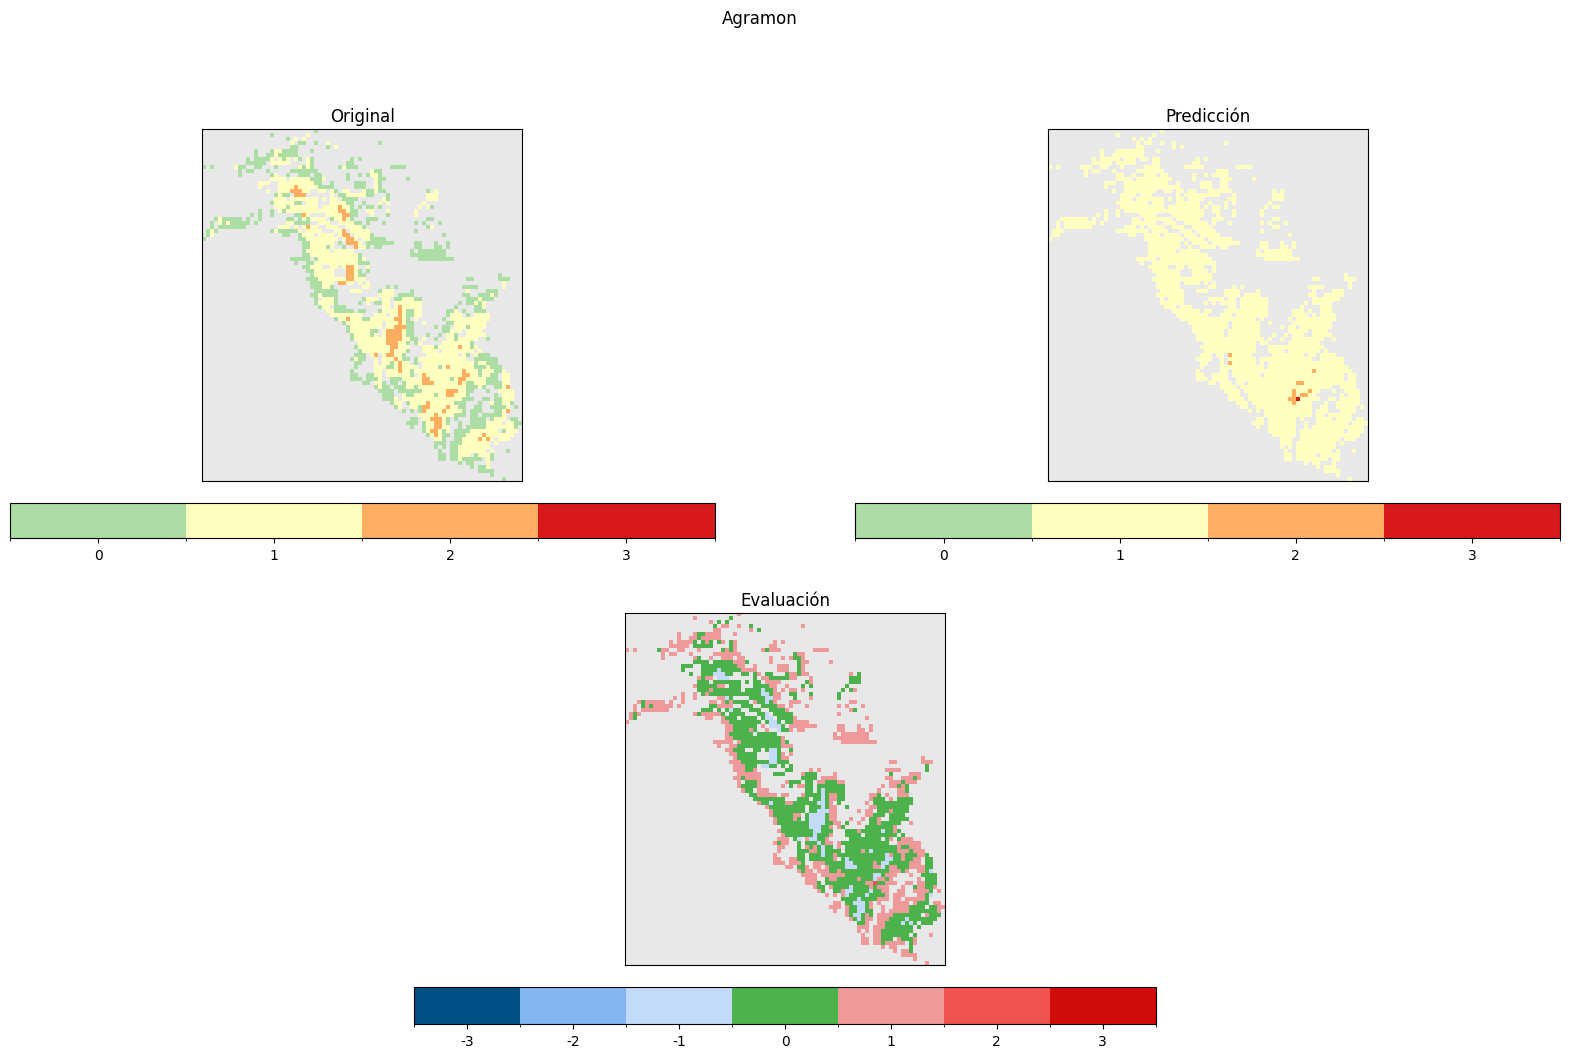

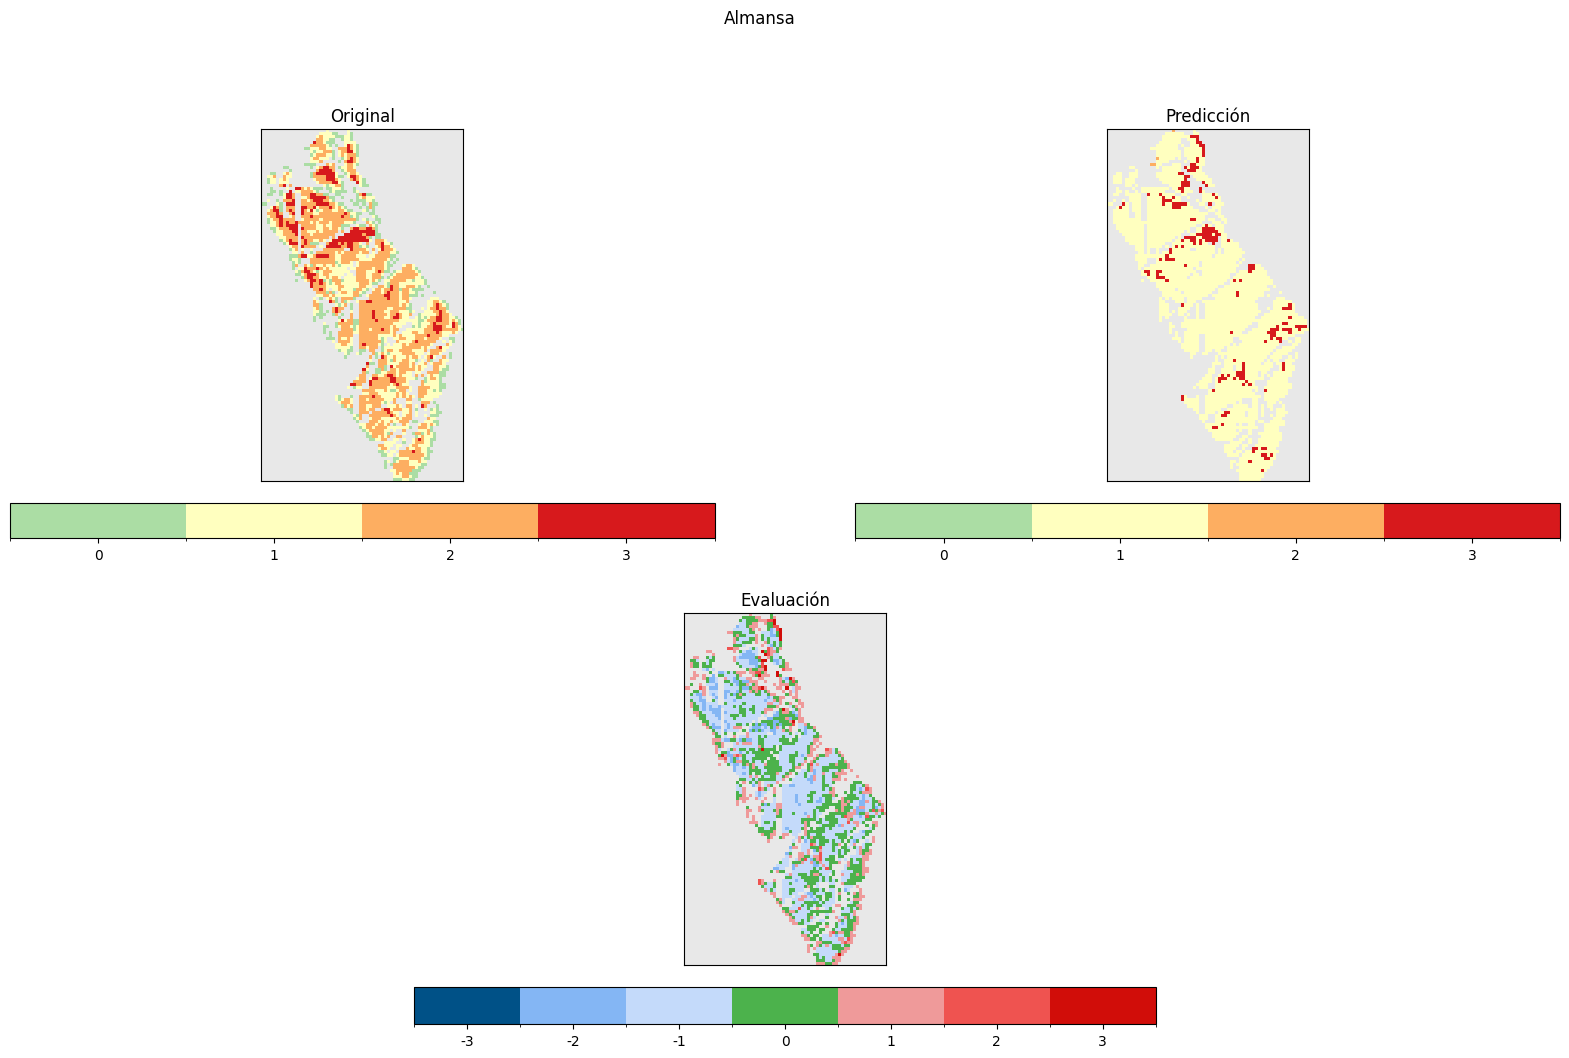

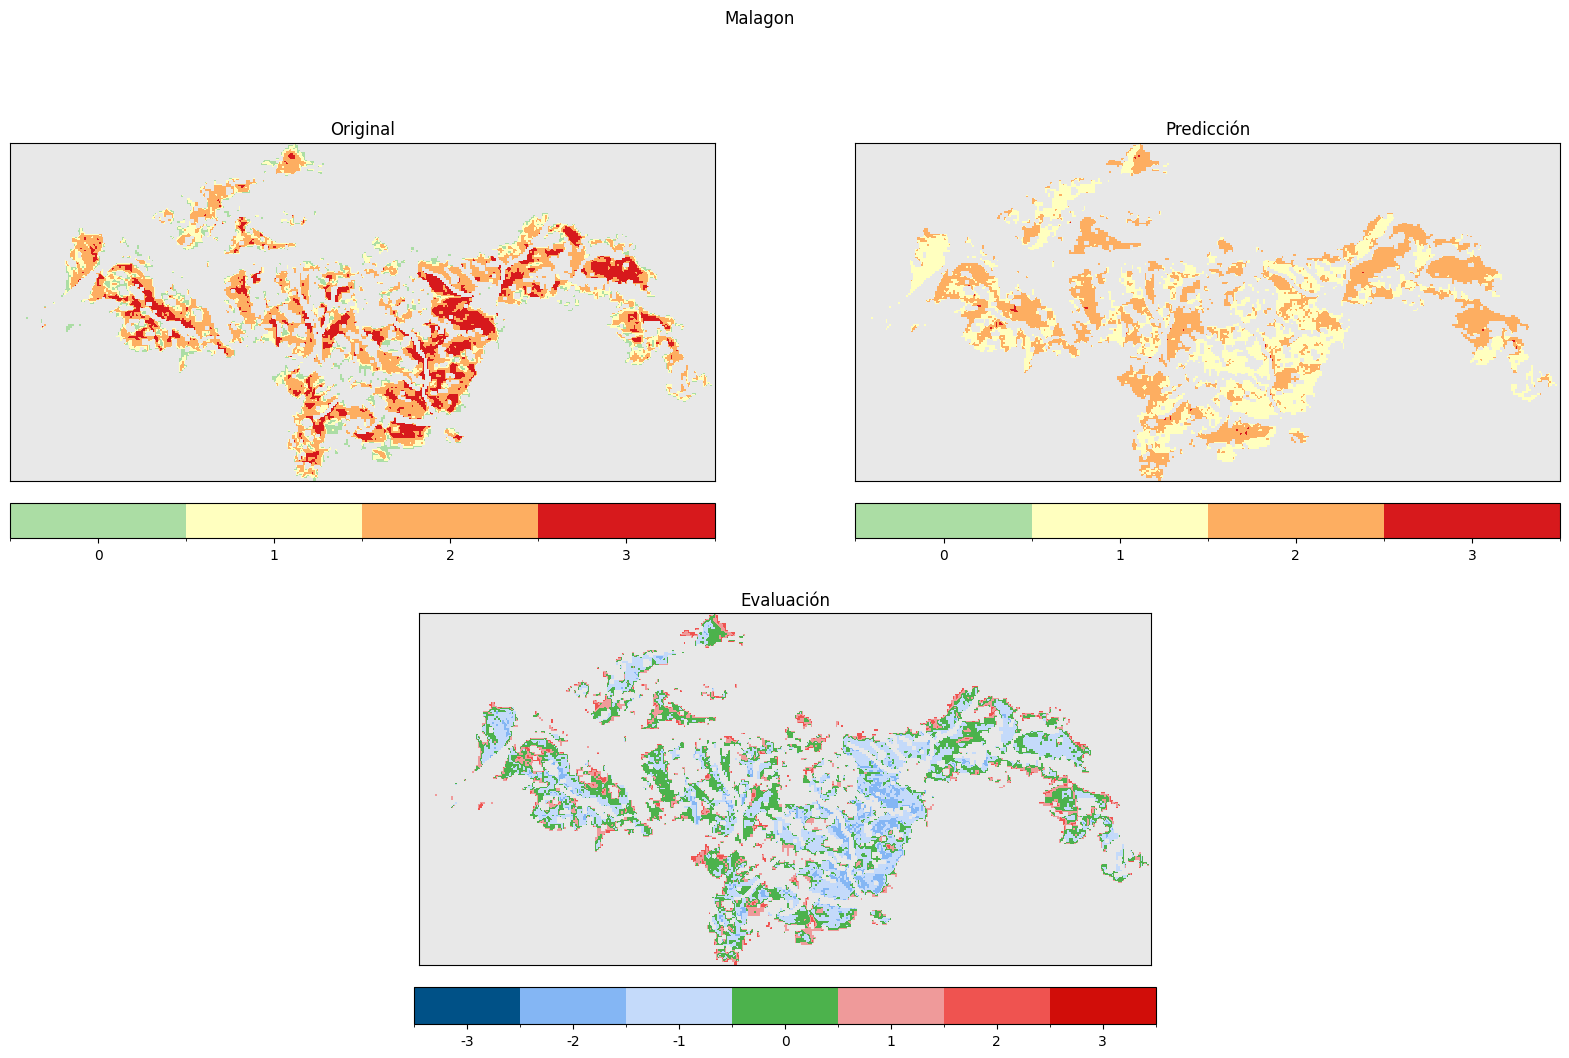

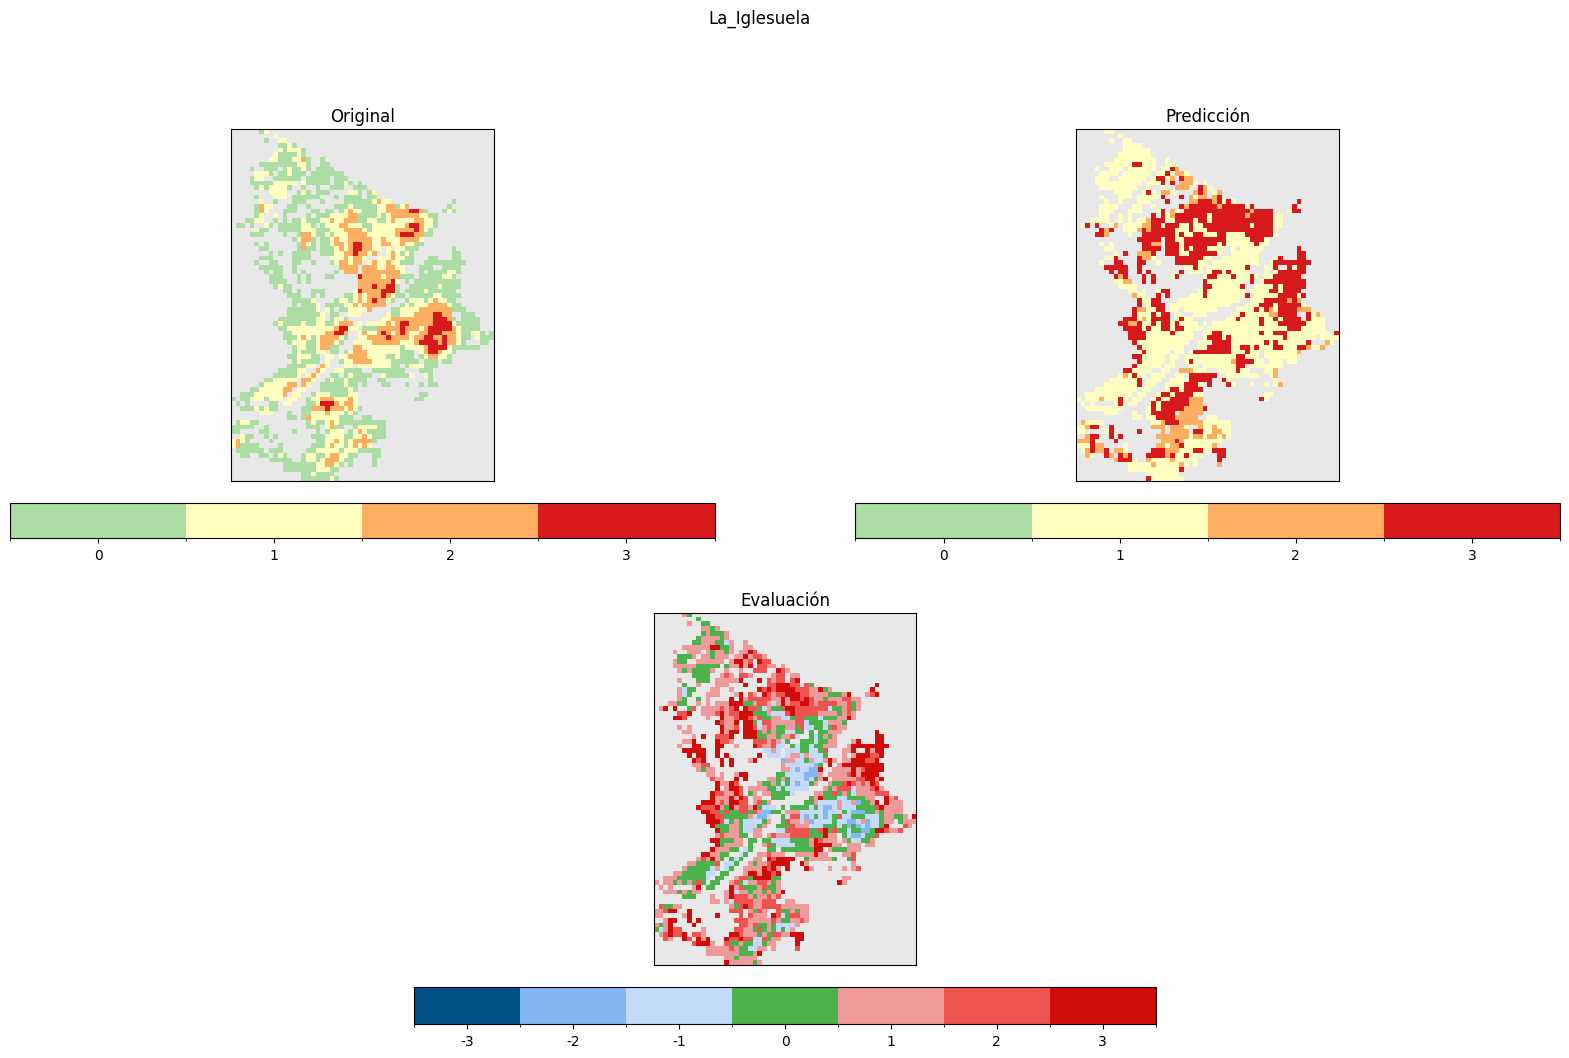

In [49]:
for fire_name in test_fire_names:
    df_fire = df_test[df_test['incendio'] == fire_name].reset_index(drop=True)

    X_fire = df_fire[variables]
    y_fire = df_fire[target_discrete]
    coords_fire = df_fire[coords_columns]

    pred = final_model['baja_alta'].predict(X_fire)
    predictions_baja_alta = pred
    pred_fire = np.zeros_like(predictions_baja_alta)

    if np.count_nonzero(predictions_baja_alta == 0) > 0:
        indexes_pred_baja = X_fire.index[predictions_baja_alta == 0]
        pred = final_model['baja_mediabaja'].predict(X_fire.loc[predictions_baja_alta == 0])


        predictions_baja_media = pred
        predictions_baja_media = np.where(predictions_baja_media == 0, 0, 1)
        pred_fire[indexes_pred_baja] = predictions_baja_media

    if np.count_nonzero(predictions_baja_alta == 1) > 0:
        indexes_pred_alta = X_fire.index[predictions_baja_alta == 1]
        pred = final_model['mediaalta_alta'].predict(X_fire.loc[predictions_baja_alta == 1])

        predictions_alta_muyalta = pred
        predictions_alta_muyalta = np.where(predictions_alta_muyalta == 0, 2, 3)
        pred_fire[indexes_pred_alta] = predictions_alta_muyalta

    matrix_fire = sm.get_severity_matrix(y_fire, coords_fire)
    matrix_pred = sm.get_severity_matrix(pred_fire, coords_fire)
    sm.show_original_prediction_evaluation_severity_matrices(matrix_fire, matrix_pred, fig_title=fire_name)